In [83]:
%load_ext autoreload
%autoreload 3
from Probe import probe_shapelet
from utils.insert_shapelet import get_pdata, insert_random, overwrite_shaplet_random
from utils.utils import pickle_load_from_file
import numpy as np
import utils
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from dtaidistance import dtw_ndim
from dtaidistance.subsequence.dtw import subsequence_alignment


from tqdm import tqdm, trange

warnings.filterwarnings("ignore")
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
device = 'cpu'

In [24]:
from tsai.models.FCN import FCN

model_path = 'models/GunPoint/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt', map_location=device)
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = read_UCR_UEA('GunPoint', None)

test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)
preds = np.load(f'{model_path}/test_preds.npy')

In [25]:
xai_name = 'DeepLift'
with open(f'attributions/GunPoint/{xai_name}/exp.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_gp = attr['attributions']

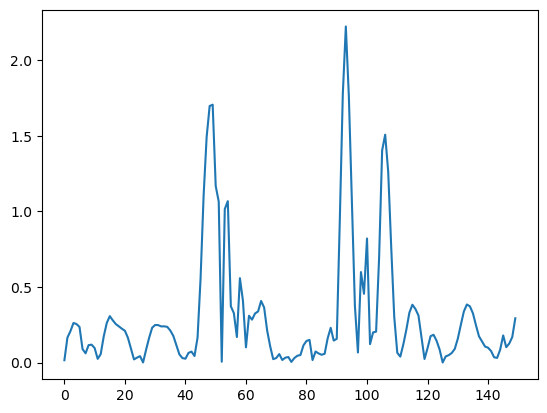

In [26]:
plt.plot(np.abs(attr_gp[2].flatten()))

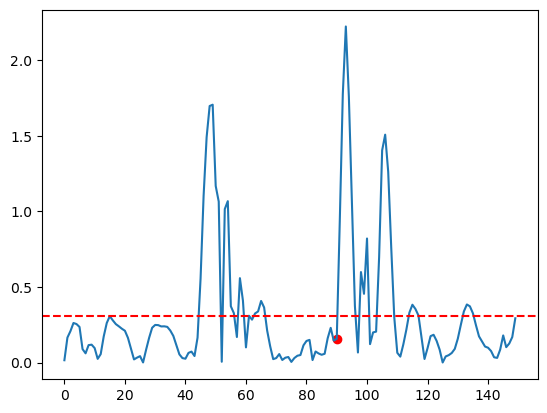

In [27]:
abs_attr = np.abs(attr_gp[2].flatten())
avg = np.mean(abs_attr)
plt.plot(np.abs(attr_gp[2].flatten()))
plt.axhline(avg, color='r', linestyle='--')
plt.scatter(90, abs_attr[90], color='r')

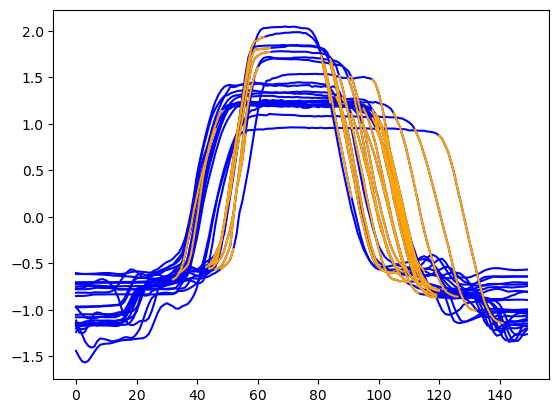

In [28]:
results = implets_class0#[0:5]
# plt.plot(np.abs(attr_gp[2].flatten()))
# for result in results:
#     _, sub_inst, sub_attr, max_score, best_start, best_end = result
#     plt.plot(np.arange(best_start, best_end + 1), sub_attr, color='orange')
#     plt.axhline(avg, color='r', linestyle='--')
#     plt.scatter(90, abs_attr[90], color='r')
# plt.show()
inst_num_set = set()
for result in results:
    inst_num, sub_inst, sub_attr, max_score, best_start, best_end = result
    inst_num_set.add(inst_num)

for inst_num in inst_num_set:
    plt.plot(train_x[inst_num].flatten(), color='blue')

for result in results:
    inst_num, sub_inst, sub_attr, max_score, best_start, best_end = result
    # print(result)

    plt.plot(np.arange(best_start, best_end + 1), sub_inst.flatten(), color='orange')

plt.show()

# plt.plot(attr_gp[2].flatten())
# for result in results:
#     i, sub_inst, sub_attr, max_score, best_start, best_end = result
#     plt.plot(np.arange(best_start, best_end + 1), attr_gp[i, best_start:best_end + 1], color='orange')
# plt.show()

In [29]:
implets_class0[3]

[3,
 array([1.5142188 , 1.3992524 , 1.2610293 , 1.1175746 , 0.95725203]),
 array([1.2650739 , 2.12043643, 2.20449734, 1.49192369, 0.76352441]),
 1.3919890880584718,
 87,
 91]

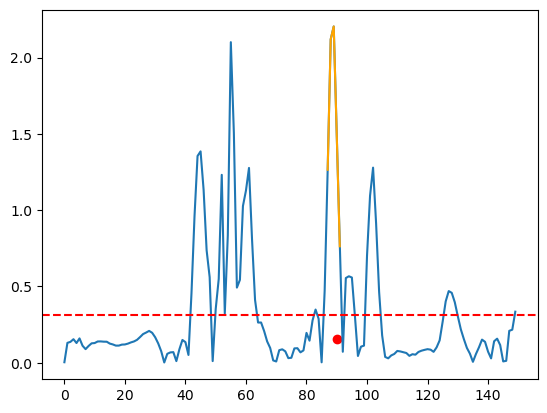

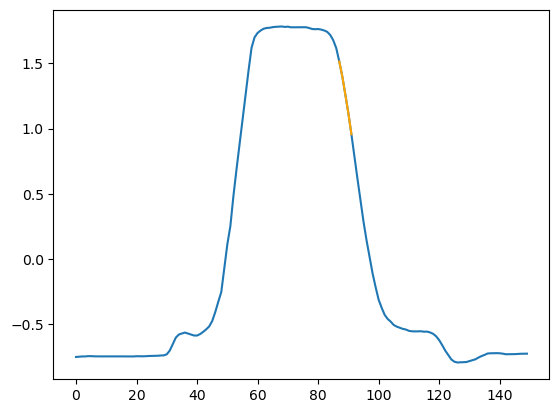

In [30]:
result = implets_class0[3]
i, sub_inst, sub_attr, max_score, best_start, best_end = result
plt.plot(np.abs(attr_gp[i].flatten()))
plt.plot(np.arange(best_start, best_end + 1), sub_attr, color='orange')
plt.axhline(avg, color='r', linestyle='--')
plt.scatter(90, abs_attr[90], color='r')
plt.show()
plt.plot(train_x[i].flatten())
plt.plot(np.arange(best_start, best_end + 1), sub_inst.flatten(), color='orange')
plt.show()

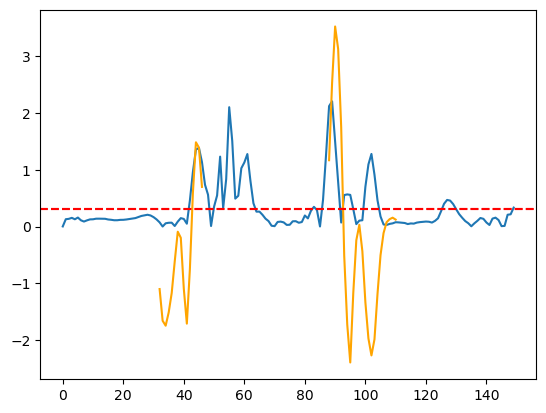

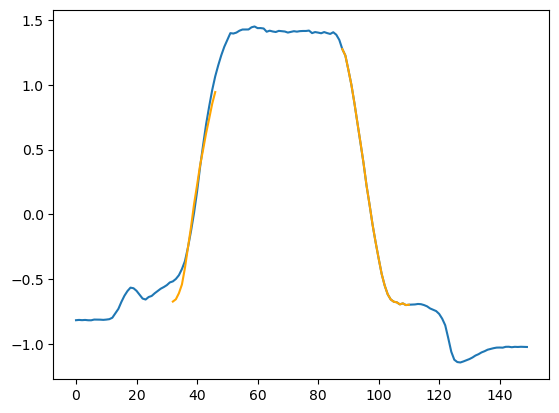

In [31]:
results = implets_class0[4:6]
plt.plot(np.abs(attr_gp[i].flatten()))
for result in results:
    i, sub_inst, sub_attr, max_score, best_start, best_end = result
    plt.plot(np.arange(best_start, best_end + 1), sub_attr, color='orange')
    plt.axhline(avg, color='r', linestyle='--')
plt.show()
plt.plot(train_x[i].flatten())
for result in results:
    i, sub_inst, sub_attr, max_score, best_start, best_end = result
    plt.plot(np.arange(best_start, best_end + 1), sub_inst.flatten(), color='orange')
plt.show()

In [32]:
# def plot_multiple_images_with_attribution(test_x, pred_y, n, shape, figsize=(12, 6), use_attribution=False,
#                                           attributions=None, normalize_attribution=True, title="", save_path=None,
#                                           test_y=None):


plot_multiple_images_with_attribution(
    np.array([imp[1] for imp in implets_class0]),
    np.array([0 for _ in implets_class0]),
    31,
    (8, 4),
    figsize=(24, 16),
    use_attribution=True,
    attributions=np.array([imp[2] for imp in implets_class0]),
    save_path='figure/implet_extract_gp.png'
)

TypeError: plot_multiple_images_with_attribution() got multiple values for argument 'figsize'

In [ ]:
from dtaidistance.clustering.kmeans import KMeans
from dtaidistance.dtw_barycenter import dba

implets_sub_class0 = [np.vstack((imp[1], imp[2])).T for imp in implets_class0]

k = 4
kmeans = KMeans(k=k)
assignment, _ = kmeans.fit(implets_sub_class0, use_c=True)

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig, axs = plt.subplots(k, 1, figsize=(6, 8))

max_importance = max([np.max(np.abs(imp[:, 1])) for imp in implets_sub_class0])
norm = Normalize(vmin=-max_importance, vmax=max_importance)

ymin = min([np.min(imp[1]) for imp in implets_sub_class0])
ymax = max([np.max(imp[1]) for imp in implets_sub_class0])


# ymin -= (ymax - ymin) * 0.1
# ymax += (ymax - ymin) * 0.1

def plot(y, v, ax, alpha=1, lw=1):
    x = np.arange(len(y))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(v)
    lc.set_alpha(alpha)
    lc.set_linewidths(lw)
    ax.add_collection(lc)


for i in range(k):
    members = assignment[i]
    for j in members:
        plot(implets_sub_class0[j][:, 0], implets_sub_class0[j][:, 1], axs[i], alpha=0.75)
    centroid = dba([implets_sub_class0[j] for j in members], None)
    # plot(centroid[:, 0], centroid[:, 1], axs[i], lw=3)
    axs[i].set_title(f'members: {str(members)}')
    axs[i].autoscale()
    axs[i].set_ylim(ymin, ymax)

plt.tight_layout()
# plt.show()
plt.savefig('figure/DTW_cluster_depDTW.png')

In [ ]:
# 1d DTW clsutering

implets_sub_class0_1d = [imp[1] for imp in implets_class0]

k = 4
kmeans = KMeans(k=k)
assignment_1d, _ = kmeans.fit(implets_sub_class0_1d, use_c=True)

In [ ]:
fig, axs = plt.subplots(k, 1, figsize=(6, 8))

max_importance = max([np.max(np.abs(imp[1])) for imp in implets_sub_class0_1d])
norm = Normalize(vmin=-max_importance, vmax=max_importance)
ymin = min([np.min(imp[1]) for imp in implets_sub_class0])
ymax = max([np.max(imp[1]) for imp in implets_sub_class0])


def plot(y, v, ax, alpha=1, lw=1):
    x = np.arange(len(y))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(v)
    lc.set_alpha(alpha)
    lc.set_linewidths(lw)
    ax.add_collection(lc)


for i in range(k):
    members = assignment_1d[i]
    centroid = dba([implets_sub_class0_1d[j] for j in members], None)
    print(centroid.shape)
    # axs[i].plot(centroid, lw=3, c='gray')
    for j in members:
        plot(implets_sub_class0_1d[j], implets_class0[j][2], axs[i], alpha=0.5)
    axs[i].set_title(f'members: {str(members)}')
    axs[i].autoscale()
    axs[i].set_ylim(ymin, ymax)

plt.tight_layout()
# plt.show()
plt.savefig('figure/DTW_cluster_1dDTW.png')

## Testing masking shaplets

In [ ]:
with open(f'attributions/GunPoint/{xai_name}/exp_test.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_test = attr['attributions']
implets_class0 = implet_extractor(test_x, test_y, attr_test, target_class=0)
implets_class1 = implet_extractor(test_x, test_y, attr_test, target_class=1)
implets = implets_class0 + implets_class1

In [ ]:
implet = implets_class0[0]
sample_id, implet_vals, implet_attr, score, start_loc, end_loc = implet
sample = test_x[sample_id].flatten()

In [ ]:
plt.plot(sample)
plt.plot(np.arange(start_loc, end_loc + 1), implet_vals, color='orange')
plt.title('original sample & implet')
plt.show()

In [ ]:
sample_overwritten = overwrite_shaplet_random(sample, start_loc, len(implet_vals))
plt.plot(sample, ls='--', label='original')
plt.plot(sample_overwritten, label='overwritten')
plt.title('replace implet w/ random')
plt.legend()
plt.show()

In [ ]:
sample_rand = insert_random(sample, len(implet_vals))
plt.plot(sample, ls='--', label='original')
plt.plot(sample_rand, label='rand insert')
plt.title('replace rand loc w/ random')
plt.legend()
plt.show()

In [ ]:
def predict(x):
    if len(x.shape) == 1:
        x = x[np.newaxis, np.newaxis, :]
    elif len(x.shape) == 2:
        x = x[np.newaxis]

    if not isinstance(x, torch.Tensor):
        x = torch.Tensor(x).to(device)

    logits = model(x).detach().cpu().numpy()
    return np.argmax(logits, axis=-1)

In [ ]:
test_x_overwritten = []
test_x_rand_insert = []

n_trials = 10

for implet in implets:
    i, _, _, _, start_loc, end_loc = implet
    implet_len = end_loc - start_loc + 1
    sample = test_x[i].flatten()
    for _ in range(n_trials):
        sample_overwritten = overwrite_shaplet_random(sample, start_loc, implet_len)
        sample_overwritten = sample_overwritten[np.newaxis]
        test_x_overwritten.append(sample_overwritten)
        
        sample_rand_insert = insert_random(sample, implet_len)
        sample_rand_insert = sample_rand_insert[np.newaxis]
        test_x_rand_insert.append(sample_rand_insert)
        
test_x_overwritten = np.array(test_x_overwritten)
test_x_rand_insert = np.array(test_x_rand_insert)


In [ ]:
y_pred_overwritten = predict(test_x_overwritten)
y_pred_rand_insert = predict(test_x_rand_insert)

In [ ]:
y_pred = predict(test_x)

In [ ]:
print(f'ori: {accuracy_score(test_y, y_pred):.4f}')

# true labels for the modified samples
y_true = np.array([test_y[i] for i, _, _, _, _, _ in implets])
y_true = np.repeat(y_true, n_trials)

print(f'overwritten: {accuracy_score(y_true, y_pred_overwritten):.4f}')
print(f'rand insert: {accuracy_score(y_true, y_pred_rand_insert):.4f}')

## Half Clustering

In [36]:
data = pickle_load_from_file(f'./output/half_implet/FCN/GunPoint/Saliency/implets_class0_cluster_results.pkl')

In [46]:
data.keys()

dict_keys(['implets', 'num_implets', 'best_k_dep', 'best_indices_dep', 'best_centroids_dep', 'best_k_1d', 'best_indices_1d', 'best_centroids_1d', 'first_half_x', 'second_half_x', 'first_half_y', 'second_half_y', 'first_half_attr', 'second_half_attr'])

In [106]:
centroids = data['best_centroids_dep']
centroid_values = [c[:, 0] for c in centroids] 

In [45]:
print(centroid_values[0].shape)
print(centroid_values[1].shape)
print(centroid_values[2].shape)


(15,)
(19,)
(11,)


In [56]:
data['implets'][0]

[2,
 array([-0.75402105, -0.7527777 , -0.75184215, -0.75130799, -0.74863895,
        -0.73878019, -0.70923808, -0.65522526, -0.60681743, -0.58119245,
        -0.56711594, -0.56298959, -0.5649777 , -0.55941778, -0.5430581 ,
        -0.52186357, -0.51709208, -0.51166747, -0.49875229]),
 array([1.55956841, 1.95173085, 1.73846495, 1.79258776, 0.79904813,
        1.70240009, 1.43758631, 0.17778969, 1.4453764 , 2.69134808,
        5.2106061 , 4.12965107, 1.94414854, 0.68024433, 1.75253797,
        1.43450665, 0.81855738, 0.00567782, 0.13580097]),
 3.368228011539108,
 27,
 45]

In [62]:
# compute intra-cluster distance on the value dim
num_clusters = len(centroids)
distances = [[] for _ in range(num_clusters)]
for j in range(num_clusters):
    centroid_value = data['best_centroids_dep'][j][:, 0]
    for i in data['best_indices_dep'][j]:
        implet_value = data['implets'][i][1]
        dist = dtw_ndim.distance(centroid_value, implet_value)
        distances[j].append(dist)

In [108]:
# the distance thresholds for each cluster
thresholds = []
for j in range(num_clusters):
    thresholds.append(np.mean(distances[j]) + 1 * np.std(distances[j]))
print(thresholds)

[1.3765832201196386, 3.54449534004274, 2.4912589422153273]


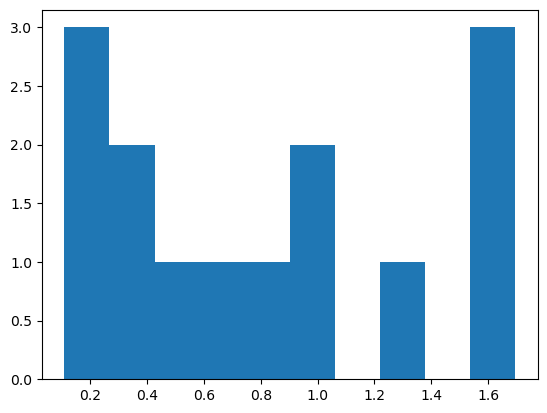

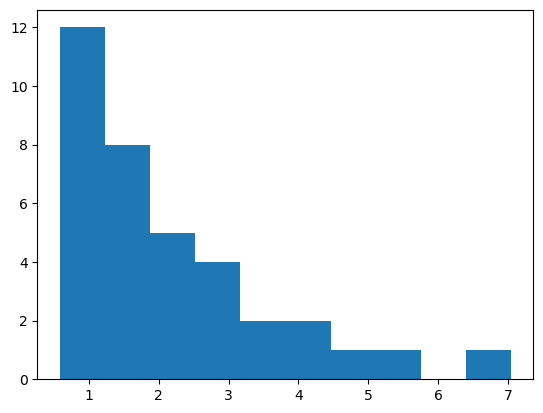

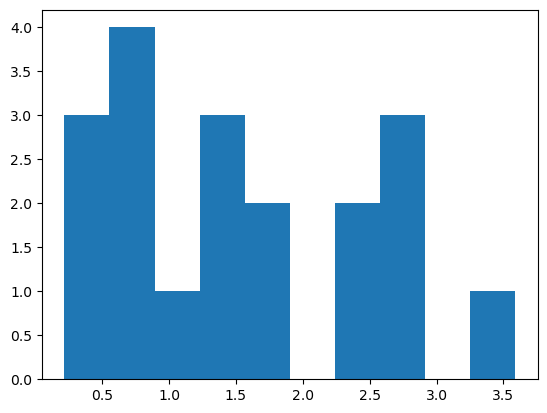

In [64]:
for j in range(num_clusters):
    plt.hist(distances[j])
    plt.show()

In [49]:
# computing distances on second half
xs = data['second_half_x']
xs = xs.squeeze()
xs.shape

(75, 150)

In [118]:
refine_stepsize = 5

identified_implets = {j: [] for j in range(num_clusters)}

for j in range(2, num_clusters):
    # plt.plot(centroid_values[j])
    # plt.show()
    for i, x in enumerate(xs):
        min_len = 3
        max_len = x.shape[0] // 2
        subseq_alignment = subsequence_alignment(centroid_values[j], x)
        match = subseq_alignment.best_match()
        print(match.segment, match.distance, thresholds[j])
        subseq_len = m.segment[1] - m.segment[0] + 1
        if match.distance <= thresholds[j] and subseq_len >= min_len and subseq_len <= max_len:
            l, r = m.segment
            # print(l, r, m.distance)
            # plt.plot(np.arange(l, r + 1), x[l: r + 1])
            identified_implets[j].append((
                i,            # instance index in the second half
                x[l:r + 1],   # subsequence
                None,         # attr, placeholder
                m.distance,   # score, the distance between the centroid and the subsequence (only in the value dim)
                l,            # staring loc
                r             # ending loc
            ))

[84, 87] 0.3573263699972968 2.4912589422153273
[42, 51] 0.33091403352600895 2.4912589422153273
[63, 73] 0.4840759684052054 2.4912589422153273
[84, 88] 0.3157527985420755 2.4912589422153273
[86, 93] 0.31609826168015137 2.4912589422153273
[84, 87] 0.32327578190523143 2.4912589422153273
[94, 98] 0.2951548393150074 2.4912589422153273
[92, 95] 0.32772334158331184 2.4912589422153273
[100, 112] 0.3218499703045719 2.4912589422153273
[39, 46] 0.7394700396531264 2.4912589422153273
[87, 90] 0.3251884360383358 2.4912589422153273
[91, 93] 0.37569182542566615 2.4912589422153273
[95, 99] 0.32976362332804454 2.4912589422153273
[92, 95] 0.34582828490253226 2.4912589422153273
[91, 95] 0.3431295370742044 2.4912589422153273
[97, 101] 0.32005663379093985 2.4912589422153273
[88, 92] 0.32128989147259845 2.4912589422153273
[89, 92] 0.3483611021719625 2.4912589422153273
[106, 114] 0.3170759528136726 2.4912589422153273
[41, 51] 0.5874714519473556 2.4912589422153273
[90, 92] 0.3411931350709938 2.4912589422153273

In [115]:
[len(s) for s in identified_implets.values()]

[0, 0, 75]